In [1]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, save_model, load_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os

MODEL_TYPE = 'adaboost'
PATH_MODELS = f"../models/train_on_blocks/{MODEL_TYPE}/"
DATASETS = [1, 4, 7]
MODEL_NAME = ''.join([MODEL_TYPE] + ['_c' + str(curr) for curr in DATASETS])
FORCE_TRAIN_AGAIN = False  # Used to force the training of a model already exported

## Load data and split learning and testing data

In [2]:
X = []
y = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y += [current_dataset] * len(X_current)
    X += X_current

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Convert data to make classification on DCT blocks and not on the whole image

In [3]:
def convert(X, y):
    res_X = []
    res_y = []
    for curr_X, curr_y in zip(X, y):
        for block in curr_X:
            res_X.append(block.reshape(64))
            res_y.append(curr_y)
    return res_X, res_y


X_train_block, y_train_block = convert(X_train, y_train)
X_test_block, y_test_block = convert(X_test, y_test)

## Training or Loading existing model

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def get_trained_model(model):
    if not (os.path.exists(os.path.join(PATH_MODELS, MODEL_NAME + '.pickle'))) or FORCE_TRAIN_AGAIN:
        print(f"Training {MODEL_NAME}, please wait...")
        model.fit(X_train_block, y_train_block)
        print(f"Saving {MODEL_NAME} at {os.path.join(PATH_MODELS, MODEL_NAME)}.pickle")
        save_model(model, PATH_MODELS, MODEL_NAME)
    else:
        print(f"Loading {MODEL_NAME}, please wait...")
        model = load_model(PATH_MODELS, MODEL_NAME)
    return model


MODELS = {
    "rf": RandomForestClassifier(max_depth=2, random_state=0),
    "adaboost": AdaBoostClassifier(),
    "svm": make_pipeline(StandardScaler(), SVC(gamma='auto', probability=False))
}

In [5]:
model = get_trained_model(MODELS[MODEL_TYPE])

Training adaboost_c1_c4_c7, please wait...
Saving adaboost_c1_c4_c7 at ../models/train_on_blocks/adaboost/adaboost_c1_c4_c7.pickle


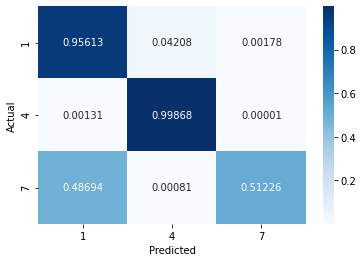

In [6]:
y_pred_block = model.predict(X_test_block)
show_confusion_matrix(y_test_block, y_pred_block, DATASETS)

In [7]:
print(classification_report(y_test_block, y_pred_block))

              precision    recall  f1-score   support

           1       0.71      0.96      0.81    175104
           4       0.94      1.00      0.97    119808
           7       1.00      0.51      0.68    141312

    accuracy                           0.82    436224
   macro avg       0.88      0.82      0.82    436224
weighted avg       0.87      0.82      0.81    436224



## Vote majoritaire

In [8]:
y_pred = []
for curr_X_test in X_test:
    curr_y_pred = model.predict(curr_X_test.reshape(curr_X_test.shape[0], curr_X_test.shape[1] * curr_X_test.shape[2]))
    unique, counts = np.unique(curr_y_pred, return_counts=True)
    y_pred.append(unique[np.argmax(counts)])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.70      1.00      0.82        57
           4       1.00      1.00      1.00        39
           7       1.00      0.46      0.63        46

    accuracy                           0.82       142
   macro avg       0.90      0.82      0.82       142
weighted avg       0.88      0.82      0.81       142



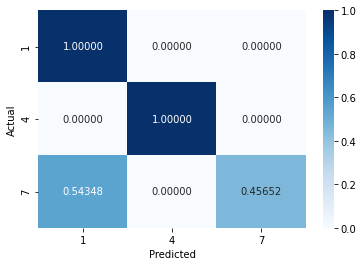

In [9]:
show_confusion_matrix(y_test, y_pred, DATASETS)
